Notebook for model (version 2) with transformed data.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/My Drive/02456 Deep learning/Final project/')
os.getcwd()

Mounted at /content/drive


'/content/drive/My Drive/02456 Deep learning/Final project'

In [2]:
## Imports

%matplotlib inline
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from pydantic import BaseModel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import random
import cv2

In [3]:
## Set up

# Paths
data_path_arrays = 'carseg_data/arrays'

# Class label map color (assume class labels have been mapped to 0-9)
class Label(BaseModel):
    class_value: int
    color: tuple
    car_part: str

class_values = range(0, 10)
colors = [(255, 255, 255), (255, 165, 0), (0, 128, 0), (255, 255, 0), (0, 255, 255),
          (128, 0, 128), (144, 238, 144), (0, 0, 255), (255, 192, 203), (0, 0, 0)]
car_parts = ["background", "hood", "front door", "rear door", "frame", "rear quater panel", "trunk lid", "fender", "bumper", "rest of car"]

classes = [Label(class_value = cv, color=c, car_part=cp) for cv, c, cp in zip(class_values, colors, car_parts)]

class_to_color = {c.class_value : c.color for c in classes}

# class_to_color = {
#     0: (255, 255, 255),  # White (Background)
#     1: (255, 165, 0),  # Orange (Hood)
#     2: (0, 128, 0),    # Dark Green (Front door)
#     3: (255, 255, 0),  # Yellow (Rear door)
#     4: (0, 255, 255),  # Cyan (Frame)
#     5: (128, 0, 128),  # Purple (Rear quarter panel)
#     6: (144, 238, 144),  # Light Green (Trunk lid)
#     7: (0, 0, 255),    # Blue (Fender)
#     8: (255, 192, 203),  # Pink (Bumper)
#     9: (0, 0, 0)      # Black (Rest of the car)
# }

In [4]:
## Utlilities

def plot_image(image, grayscale=False):
    # Plots a single image on rgb 0-255 scale
    if torch.is_tensor(image):
        image = image.detach().cpu().permute((1, 2, 0)).numpy()
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        cmap = 'gray' if grayscale else None
        plt.imshow(image, cmap=cmap)
        plt.axis('off')
        plt.show()


def segment_image(image, labels):
    # Segments an image based on class labels using color map
    # Returns segmented image as tensor
    if torch.is_tensor(image):
        # Convert tensor to numpy arrays
        image = image.detach().cpu().permute(1, 2, 0).numpy()
        labels = labels.detach().cpu().numpy()

    # Create (rows, cols, 3) array
    segmented_image = np.zeros(image.shape[:2]+(3,))

    # Color the pixels based on the class values
    # Excluding class 0 and class 90 if want to include background and rest of the car
    for class_value, color in class_to_color.items():
        #if class_value != 0 and class_value != 90:
        segmented_image[labels == class_value] = color

    # If want to include background and rest of the car
    # segmented_image[label == 0] = image[label == 0]
    # segmented_image[label == 90] = image[label == 90]

    # Convert to tensor
    segmented_image = torch.from_numpy(segmented_image).permute(2, 0, 1).long()

    return segmented_image

def plot_grid_segmented_images(images, labels, grayscale=False):
    # Plots a grid of segmented images (tensors)
    segmented_images = []
    for image, label in zip(images, labels):
        segmented_image = segment_image(image, label)
        segmented_images.append(segmented_image)

    plot_image(torchvision.utils.make_grid(segmented_images, nrow=4), grayscale=grayscale)


In [20]:
## Transform images

# Convert to grayscale since there should be no benifit (I think) by using colors
# for segmenting the car parts (most of the time the car is made of the same color
# anyways so...)

grayscale = False
skip_rest_of_car = False
image_size = (256,256)


def add_gaussian_noise(image, mean=0, std=0.4):
    noise = np.random.normal(mean, std, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image


def adjust_brightness_contrast(image, brightness_factor=0.2, contrast_factor=0.2):
    # Adjust brightness and contrast using OpenCV
    image = cv2.convertScaleAbs(image, alpha=1 + brightness_factor, beta=0)
    image = cv2.addWeighted(image, 1 + contrast_factor, np.zeros_like(image), 0, 0)

    return image


def transform(image, label):
    # Function to transform data (training and testing)

    #image = adjust_brightness_contrast(image)

    # Convert to grayscale
    if grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Resize image
    # image = cv2.resize(image, image_size, interpolation=cv2.INTER_LINEAR)
    # label = cv2.resize(label, image_size, interpolation=cv2.INTER_NEAREST)
    # NOT NECESARRY WHEN NOT AUGMENTING A CERTAIN WAY

    # Add channel dimension if grayscale
    if grayscale:
        image = np.expand_dims(image, axis=-1)

    return image, label


def augment(image, label):
    # Function to augment data (training data)

    # # Add gaussian noise to image
    # image = add_gaussian_noise(image)

    # # Randomly scale the image and label
    # scale_x = random.uniform(1.0, 1.2)
    # scale_y = random.uniform(1.0, 1.2)
    # image = cv2.resize(image, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
    # label = cv2.resize(label, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_NEAREST)

    # # Randomly crop the image and label
    # final_shape = image_size
    # rows, cols = image.shape[:2]
    # x = random.randint(0, cols - final_shape[1])
    # y = random.randint(0, rows - final_shape[0])
    # image = image[y:y + final_shape[0], x:x + final_shape[1]]
    # label = label[y:y + final_shape[0], x:x + final_shape[1]]

    # # Randomly adjust the color of the image
    # if not grayscale:
    #     r_adjust = random.uniform(0.5, 1.5)
    #     g_adjust = random.uniform(0.5, 1.5)
    #     b_adjust = random.uniform(0.5, 1.5)
    #     image[:, :, 0] = image[:, :, 0] * r_adjust
    #     image[:, :, 1] = image[:, :, 1] * g_adjust
    #     image[:, :, 2] = image[:, :, 2] * b_adjust
    #     image[image > 255] = 255
    #     image[image < 0] = 0

    # Flip the image and label horizontally with a 50% chance
    if random.choice([True, False]):
        image = cv2.flip(image, 1)  # Horizontal flip
        label = cv2.flip(label, 1)  # Horizontal flip for label

    # # Flip the image and label vertically with a 50% chance
    # if random.choice([True, False]):
    #     image = cv2.flip(image, 0)  # Vertical flip
    #     label = cv2.flip(label, 0)  # Vertical flip for label

    # Rotate the image and label slightly (up to +/- 15 degrees)
    angle = random.uniform(-15, 15)
    rows, cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR)
    label = cv2.warpAffine(label, rotation_matrix, (cols, rows), flags=cv2.INTER_NEAREST)

    return image, label


def remove_rest_of_car(labelled_image):
    rest_of_car_label = 9
    labelled_image[labelled_image == rest_of_car_label] = 0
    return labelled_image


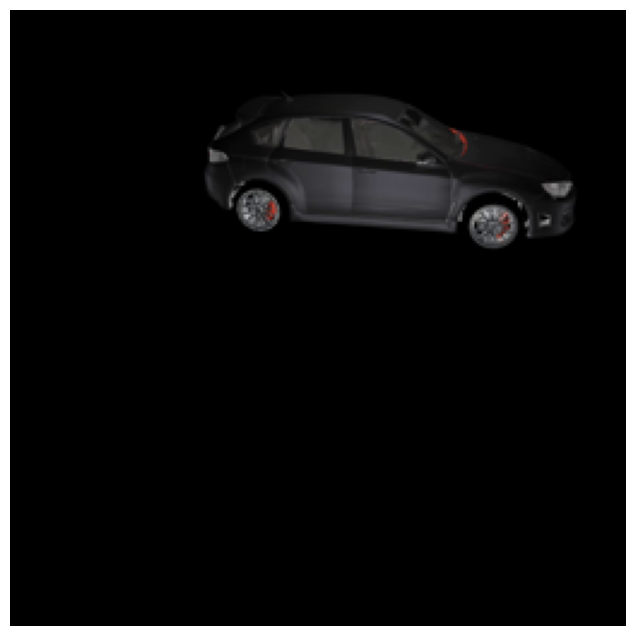

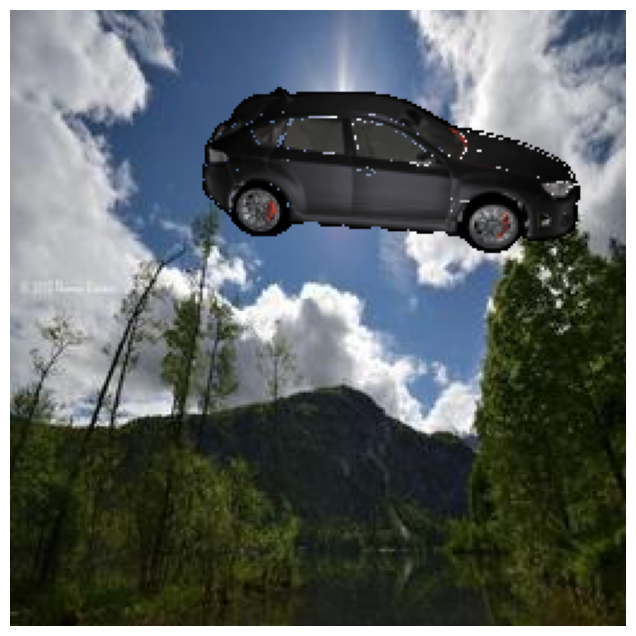

In [6]:
## Add backgrounds to cad images

backgrounds_path = 'carseg_data/landscapes_npy'
#backgrounds_files = random.sample([file for file in os.listdir(backgrounds_path)], 100)   # only use subset of 100 backgrounds to speed up training

def add_background(image, mask):
    # Function that adds a random background to an image with mask
    # bg_filename = f"{random.randint(1, 4315)}.npy"
    # bg_image_path = os.path.join(backgrounds_path, bg_filename)
    # print(bg_image_path)
    # background = np.load(bg_image_path)
    #background_file = random.choice(backgrounds_files)
    background_file = f"{random.randint(1, 400)}.npy"   # TODO: spurning hvort við viljum velja úr öllum bakgrunnum - kannski of ólíkt?
    background = np.load(os.path.join(backgrounds_path, background_file))
    #background = cv2.resize(background, image_size, interpolation=cv2.INTER_LINEAR)
    background_pixels = (mask == 0)
    image[background_pixels] = background[background_pixels]
    return image

car_img = np.load('carseg_data/arrays/black_5_doors_0002.npy')
img = car_img[:,:,:3]
mask = car_img[:,:,3]
plot_image(img)
img = add_background(img, mask)
plot_image(img)

In [21]:
## Segmented image data

#num_cad_img = 800   # number of cad images for black and orange, respectively
num_real_duplicates = 28   # number of copy's of real images   (~28 if we use all black and orange cad to have balance)
test_idx = np.arange(1,31)
test_ids = [f"photo_00{i:02d}.npy" for i in test_idx]
real_image_pattern = re.compile(r'.*photo.*')
black_cad_pattern = re.compile(r'.*black.*')
orange_cad_pattern = re.compile(r'.*orange.*')

class SegmentedImageDataset(TensorDataset):
    def __init__(self, data_folder_arrays, train, transform=None):
        self.data_folder = data_folder_arrays
        self.data_files = os.listdir(data_folder_arrays)
        self.real_single = []
        self.real_duplicates = []
        self.black = []
        self.orange = []
        self.train = train
        self.transform = transform
        if self.train:
            # Exclude the test filenames to create the training dataset
            self.data_files = [file for file in self.data_files if file not in test_ids]
            # All real images of cars
            self.real_single = [file for file in self.data_files if real_image_pattern.match(file)]
            self.real_duplicates = []
            # Create num_real_dupclicates duplicates of the real images (to balance dataset but then will be augmented)
            for i in range(num_real_duplicates):
                self.real_duplicates.extend(self.real_single)
            # num_cad_image random black cad images and num_cad_image random orange cad images
            self.black = [file for file in self.data_files if black_cad_pattern.match(file)]
            #self.black = random.sample(self.black, num_cad_img)
            self.orange = [file for file in self.data_files if orange_cad_pattern.match(file)]
            #self.orange = random.sample(self.orange, num_cad_img)
            # Concatenate
            self.data_files = self.real_duplicates + self.black + self.orange
        else:
            # Include only the test filenames for the test dataset
            self.data_files = [file for file in self.data_files if file in test_ids]

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        file_name = os.path.join(self.data_folder, self.data_files[idx])
        image_data = np.load(file_name)
        image = image_data[:,:,:3]
        class_labels = image_data[:,:,3]
        class_labels = class_labels//10   # map class labels to 0-9
        # Add random background to image in train dataset
        if self.train:
            image = add_background(image, class_labels)
        # Augment training data
        if self.train:
            image, class_labels = augment(image, class_labels)
        # Transform (all data)
        # if self.transform:
        #     image, class_labels = self.transform(image, class_labels)

        # min-max normalization for the image
        image = (image - np.min(image)) / (np.max(image) - np.min(image))

        if skip_rest_of_car:
            class_labels = remove_rest_of_car(class_labels)

        return torch.from_numpy(image).permute(2, 0, 1).float(), torch.tensor(class_labels).long()

    def split_train_validation(self, validation_split):
        # Function to split data into training and validation sets
        num_val_samples_real_single = int(validation_split*len(self.real_single))
        num_val_samples_black = int(validation_split*len(self.black))
        num_val_samples_orange = int(validation_split*len(self.orange))

        random.shuffle(self.real_single)
        random.shuffle(self.black)
        random.shuffle(self.orange)

        # Need to make sure that we don't take duplicates for train and validation (because we are making copy's of real images)
        real_train_file_unique = self.real_single[:-num_val_samples_real_single]
        real_val_file_unique = self.real_single[-num_val_samples_real_single:]
        real_train = [file for file in self.real_duplicates if file in real_train_file_unique]
        real_val = [file for file in self.real_duplicates if file in real_val_file_unique]
        # Same for CAD images (since we can't just split the self.data_files list anymore)
        black_train_file_unique = self.black[:-num_val_samples_black]
        black_val_file_unique = self.black[-num_val_samples_black:]
        black_train = [file for file in self.black if file in black_train_file_unique]
        black_val = [file for file in self.black if file in black_val_file_unique]
        orange_train_file_unique = self.orange[:-num_val_samples_orange]
        orange_val_file_unique = self.orange[-num_val_samples_orange:]
        orange_train = [file for file in self.orange if file in orange_train_file_unique]
        orange_val = [file for file in self.orange if file in orange_val_file_unique]

        return real_train+black_train+orange_train, real_val+black_val+orange_val


batch_size = 16
num_workers = 8
validation_split = 0.1

train_dataset = SegmentedImageDataset(data_folder_arrays=data_path_arrays, train=True, transform=transform)
validation_dataset = SegmentedImageDataset(data_folder_arrays=data_path_arrays, train=True, transform=transform)
test_dataset = SegmentedImageDataset(data_folder_arrays=data_path_arrays, train=False, transform=transform)
train_dataset.data_files, validation_dataset.data_files = train_dataset.split_train_validation(validation_split)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [22]:
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

6052
647
30


In [ ]:
print('Training data:')
images_train, masks_train = next(iter(train_dataloader))
plot_image(torchvision.utils.make_grid(images_train, nrow=4), grayscale=grayscale)

print('Validation data:')
images_val, masks_val = next(iter(validation_dataloader))
plot_image(torchvision.utils.make_grid(images_val, nrow=4), grayscale=grayscale)

print('Testing data:')
images_test, masks_test = next(iter(test_dataloader))
plot_image(torchvision.utils.make_grid(images_test, nrow=4), grayscale=grayscale)

Output hidden; open in https://colab.research.google.com to view.

Training data:


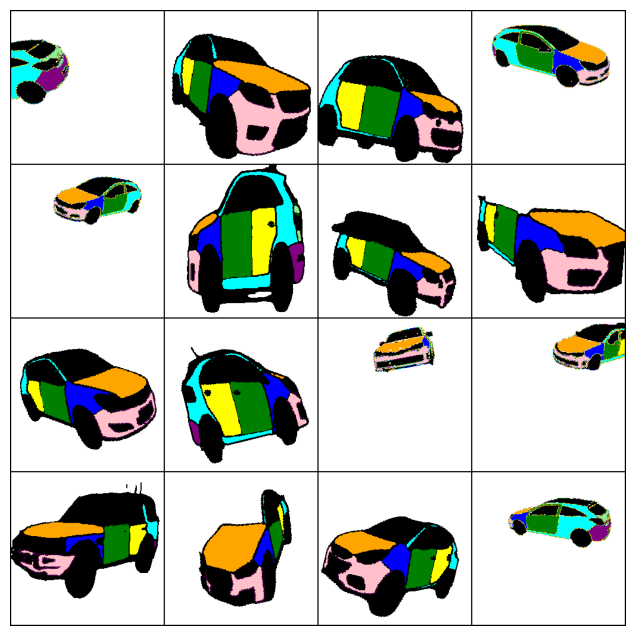

Validation data:


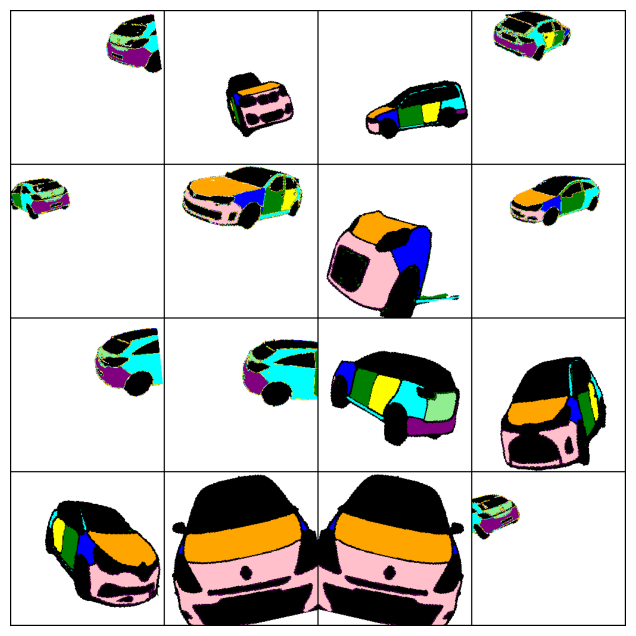

Testing data:


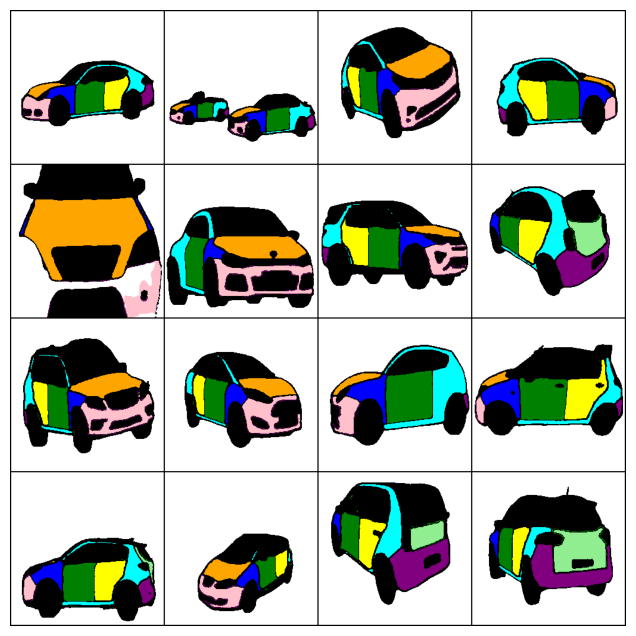

In [ ]:
print('Training data:')
plot_grid_segmented_images(images_train, masks_train)

print('Validation data:')
plot_grid_segmented_images(images_val, masks_val)

print('Testing data:')
plot_grid_segmented_images(images_test, masks_test)

In [ ]:
# TODO: mynd neðst í vinstra horni er léleg í test gögnum... (kannski taka hana út eða replace-a með gömul því hún var betri minnir mig
# þetta gæti nefnilega haft mikil áhrif á niðurstöðuna sem við fáum úr test)

In [23]:
##bigger model

# STÆKKAÐI AÐEINS (og meira og meira)
class UNet_bigger(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.3):
        super(UNet_bigger, self).__init__()

        # Contracting path
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.enc5 = self.conv_block(512, 1024)


        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self.conv_block(1024, 2048, num_layers=5)

        # Expanding path
        self.up1 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(2048, 1024, num_layers=3)  # Increased layers
        self.up2 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.up4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(256, 128)
        self.up5 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec5 = self.conv_block(128, 64)

        # Dropout
        self.dropout1 = nn.Dropout(dropout_p)
        self.dropout2 = nn.Dropout(dropout_p)
        self.dropout3 = nn.Dropout(dropout_p)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        c1 = self.enc1(x)
        p1 = self.pool(c1)
        p1 = self.dropout1(p1)

        c2 = self.enc2(p1)
        p2 = self.pool(c2)
        p2 = self.dropout1(p2)

        c3 = self.enc3(p2)
        p3 = self.pool(c3)
        p3 = self.dropout1(p3)

        c4 = self.enc4(p3)
        p4 = self.pool(c4)
        p4 = self.dropout1(p4)

        c5 = self.enc5(p4)
        p5 = self.pool(c5)
        p5 = self.dropout1(p5)

        # Bottleneck
        bottleneck = self.bottleneck(p5)

        # Expanding path
        up1 = self.up1(bottleneck)
        merge1 = torch.cat([up1, c5], dim=1)
        d1 = self.dec1(merge1)
        d1 = self.dropout1(d1)

        up2 = self.up2(d1)
        merge2 = torch.cat([up2, c4], dim=1)
        d2 = self.dec2(merge2)
        d2 = self.dropout1(d2)

        up3 = self.up3(d2)
        merge3 = torch.cat([up3, c3], dim=1)
        d3 = self.dec3(merge3)
        d3 = self.dropout1(d3)

        up4 = self.up4(d3)
        merge4 = torch.cat([up4, c2], dim=1)
        d4 = self.dec4(merge4)
        d4 = self.dropout1(d4)

        up5 = self.up5(d4)
        merge5 = torch.cat([up5, c1], dim=1)
        d5 = self.dec5(merge5)
        d5 = self.dropout1(d5)

        out = self.out(d5)
        return out

    def conv_block(self, in_channels, out_channels, num_layers=2):
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        return nn.Sequential(*layers)


class UNet_big(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.5):
        super(UNet_big, self).__init__()

        # Contracting path
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Expanding path
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(128, 64)

        # Dropout
        self.dropout1 = nn.Dropout(dropout_p)
        self.dropout2 = nn.Dropout(dropout_p)
        self.dropout3 = nn.Dropout(dropout_p)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        c1 = self.enc1(x)
        p1 = self.pool(c1)
        p1 = self.dropout1(p1)

        c2 = self.enc2(p1)
        p2 = self.pool(c2)
        p2 = self.dropout1(p2)

        c3 = self.enc3(p2)
        p3 = self.pool(c3)
        p3 = self.dropout1(p3)

        c4 = self.enc4(p3)
        p4 = self.pool(c4)
        p4 = self.dropout1(p4)

        # Bottleneck
        bottleneck = self.bottleneck(p4)

        # Expanding path
        up1 = self.up1(bottleneck)
        merge1 = torch.cat([up1, c4], dim=1)
        d1 = self.dec1(merge1)
        d1 = self.dropout1(d1)


        up2 = self.up2(d1)
        merge2 = torch.cat([up2, c3], dim=1)
        d2 = self.dec2(merge2)
        d2 = self.dropout1(d2)

        up3 = self.up3(d2)
        merge3 = torch.cat([up3, c2], dim=1)
        d3 = self.dec3(merge3)
        d3 = self.dropout1(d3)

        up4 = self.up4(d3)
        merge4 = torch.cat([up4, c1], dim=1)
        d4 = self.dec4(merge4)
        d4 = self.dropout1(d4)

        out = self.out(d4)
        return out

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

# smaller model
## Model

import torch
import torch.nn as nn

# JUST ADDED DROPOUT TO SMALL MODEL
class UNet_small(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.5):
        super(UNet_small, self).__init__()

        # Contracting path
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #self.bottleneck = self.conv_block(128, 256)

        # Expanding path
        self.up1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128 + 64, 64)
        self.up2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(64 + 32, 32)

        self.dropout1 = nn.Dropout(dropout_p)
        self.dropout2 = nn.Dropout(dropout_p)
        self.dropout3 = nn.Dropout(dropout_p)

        self.out = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        c1 = self.enc1(x)
        p1 = self.pool(c1)
        p1 = self.dropout1(p1)

        c2 = self.enc2(p1)
        p2 = self.pool(c2)
        p2 = self.dropout1(p2)

        c3 = self.enc3(p2)
        c3 = self.dropout1(c3)

        #bottleneck = self.bottleneck(p3)

        # Expanding path
        up1 = self.up1(c3)
        merge1 = torch.cat([up1, c2], dim=1)
        d1 = self.dec1(merge1)
        d1 = self.dropout1(d1)

        up2 = self.up2(d1)
        merge2 = torch.cat([up2, c1], dim=1)
        d2 = self.dec2(merge2)
        d2 = self.dropout1(d2)

        out = self.out(d2)
        return out

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )


# Create the model
# model = UNet_bigger(in_channels=3, out_channels=10)
# print(model)


In [ ]:
# ## Custom loss functions - (NOT WORKING ATM)

# # TODO: nota þetta loss í staðinn fyrir það sem halldór er með (getum notað vigtir hér líka!)
# # En fyrst þarf ég að finna út úr afhverju módelin sökka eftir að ég notaði augmentation/transformation...

# # https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch

# # En er ekki alltaf sama vesen með að inputs eru bara tölur á bilinu 0-1 (ef við notum sigmoid en targets eru
# # class labesl sem eru discrete 0-9...???) - ef ég nota argmax þá aftengjumst við computational graph og
# # allt fer í rugl

# # ATH. þettaa er binary!!
# class DiceBCELoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceBCELoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):

#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)

#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)

#         intersection = (inputs * targets).sum()
#         dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
#         BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
#         Dice_BCE = BCE + dice_loss

#         return Dice_BCE

# class IoULoss(nn.Module):
#     def __init__(self, num_classes, smooth=1e-6):
#         super(IoULoss, self).__init__()
#         self.num_classes = num_classes
#         self.smooth = smooth

#     def forward(self, logits, targets):
#         #print(logits.grad_fn)
#         # Apply softmax to get class probabilities
#         probs = F.softmax(logits, dim=1)
#         #print(probs.grad_fn)

#         # Kannski ætti ég líka að one-hot encode-a targets...
#         # Já held að þetta sé gert þannig venjulega í flestum loss functions...

#         # Calculate IoU for each class
#         iou_sum = 0.0
#         for i in range(self.num_classes):
#             true_class = targets == i
#             pred_class = probs[:, i, :, :]
#             intersection = torch.sum(true_class.float() * pred_class)
#             union = torch.sum(true_class.float()) + torch.sum(pred_class) - intersection
#             iou = (intersection + self.smooth) / (union + self.smooth)
#             iou_sum += iou

#         # Average IoU over all classes
#         average_iou = iou_sum / self.num_classes

#         # Convert IoU to IoU loss
#         iou_loss = 1.0 - average_iou

#         return iou_loss

#     # def forward(self, outputs, targets):
#     #     print(outputs.grad_fn)
#     #     outputs = torch.argmax(outputs, dim=1).float()   # get class value from logits
#     #     #outputs.requires_grad=True
#     #     print(outputs.grad_fn)
#     #     iou_sum = 0.0
#     #     for i in range(self.num_classes):
#     #         true_class = (targets== i)
#     #         pred_class = (outputs == i)
#     #         intersection = torch.sum(true_class * pred_class)
#     #         union = torch.sum(true_class ) + torch.sum(pred_class) - intersection
#     #         iou = (intersection + self.smooth) / (union + self.smooth)
#     #         iou_sum += iou

#     #     return Variable(1-iou_sum/self.num_classes, requires_grad=True)


# class DiceLoss(nn.Module):
#     def __init__(self, num_classes, smooth=1e-6):
#         super(DiceLoss, self).__init__()
#         self.num_classes = num_classes
#         self.smooth = smooth

#     def forward(self, outputs, targets):
#         dice_sum = 0.0
#         for i in range(self.num_classes):
#             true_class = (targets == i)
#             pred_class = (outputs == i)
#             intersection = torch.sum(true_class * pred_class)
#             union = torch.sum(true_class) + torch.sum(pred_class)
#             dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
#             dice_sum += dice

#         return 1-dice_sum/self.num_classes



In [ ]:
## Focal loss

# https://amaarora.github.io/posts/2020-06-29-FocalLoss.html
# https://arxiv.org/abs/1708.02002

# A bit confused about how it is supposed to be for multiclass problems...
# alpha and weights is the confusing part...

# So here we use weighted CE loss and then use the gamma factor for
# focusing on handling hard examples to classify (and basically
# not using alpha or instead using the weights in CE)

class FocalLossMultiClass(torch.nn.Module):
    def __init__(self, weights=None, gamma=2, reduction='mean'):
        super(FocalLossMultiClass, self).__init__()
        self.weights = weights
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weights)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss



In [24]:
## Model configuration

# Constants
num_classes = 9 if skip_rest_of_car else 10
num_channels = 1 if grayscale else 3

# Class weights


# Loss


In [15]:
## Custom loss function (Halldór)

# Import custom loss function
from bi_tempered_loss import bi_tempered_logistic_loss

def calculate_class_weights(num_classes=10):

    # Calculate fractions -> weights
    fractions = {c: np.array([]) for c in range(0,num_classes)}   # use num_classes if we decide to skip rest of the car
    pixels_per_img = image_size[0]*image_size[1]

    # Process each image in train dataset
    for images, masks in train_dataloader:
        images = images.detach().cpu().numpy()
        masks = masks.detach().cpu().numpy()
        for image, mask in zip(images, masks):
            # # Count the pixels that are not background for the current image
            # non_background_pixels = np.sum(mask != 0)

            # Calculate the fraction for each segment in the current image
            for segment in range(0,num_classes):
                segment_pixels = np.sum(mask == segment)
                fraction = segment_pixels / pixels_per_img

                # Append the fraction to the list for the segment
                fractions[segment] = np.append(fractions[segment], fraction)

    # Now 'fractions' contains an array of fractions for each segment across all images
    average_fractions = np.zeros(num_classes)

    for segment, fraction_array in fractions.items():
        average_fractions[segment] = np.mean(fraction_array)

    print(average_fractions)
    print(sum(average_fractions))

    # Get weigths from fractions
    inv_fractions = 1/average_fractions
    print(inv_fractions)
    #inv_fractions[1:-1] = inv_fractions[1:-1]*10
    #print(inv_fractions)
    inv_fractions = inv_fractions/sum(inv_fractions)   # normalize weights
    # inv_fractions[1:-1]= inv_fractions[1:-1]*10

    return inv_fractions


weights = calculate_class_weights(num_classes)

[0.69409991 0.02663033 0.02750492 0.01245137 0.01874395 0.01355118
 0.00766253 0.01230075 0.02600099 0.16105407]
1.0
[  1.44071479  37.55116673  36.35713131  80.312457    53.35053361
  73.79431825 130.50516938  81.29582418  38.46007898   6.20909505]


In [16]:
weights

array([0.00267157, 0.06963249, 0.06741835, 0.14892631, 0.09892983,
       0.13683949, 0.24200048, 0.1507498 , 0.07131792, 0.01151375])

In [27]:
## Model evaluation while training

def dice_coefficient(preds, targets, num_classes=num_classes):
    dice = np.zeros(num_classes)
    for class_id in range(num_classes):
        pred = (preds == class_id).float()
        target = (targets == class_id).float()
        intersect = (pred * target).sum()
        union = pred.sum() + target.sum()
        if target.sum()>10:
          dice[class_id] = (2. * intersect + 1e-6) / (union + 1e-6)
        else:
          dice[class_id] = np.nan
    return dice

In [28]:
## Model configuration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet_big(in_channels=num_channels, out_channels=num_classes).to(device)
class_weights = torch.tensor(weights,device=device).float()
#criterion = bi_tempered_logistic_loss
#criterion = nn.CrossEntropyLoss(weight=class_weights)
#criterion = FocalLossMultiClass()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)   #lr=0.0005
#optimizer = torch.optim.SGD(model.parameters(), lr=0.000005, momentum=0.9)

In [ ]:
device

device(type='cuda')

In [ ]:
## Train

labels = 0.001   #label_smoothing: Label smoothing parameter between [0, 1)
t1 =  0.85    #t1: Temperature 1 (< 1.0 for boundedness), lower number -> less confident model, preventing overfitting
t2 = 1.3        #t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support) hihgher number -> more robust to outliers in data

# path_to_model = 'model_baseline_classbalance_1500train_augment_background_mirror_rotate_no_weights_cross_entropy_30epochs_loss_03236_03873_train_val_againoverfitbutless_lowestdice_class_score_3_008score_train_6_010_val_6_0008_test_022_avg'
# model = torch.load(path_to_model).to(device)
# SEEMS LIKE WHEN I TRY TO CONTINUE TO TRAIN MODEL IT GETS STUCK... MAYBE IT IS NOT POSSIBLE?

#num_epochs = 200
num_epochs = 40
dice_loss_train_store = np.zeros([num_epochs,num_classes])
dice_loss_test_store = np.zeros([num_epochs,num_classes])

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_training_loss = 0.0
    epoch_training_dice_scores = np.zeros(num_classes)

    # Wrap dataloader with tqdm for a loading bar
    for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        #loss = criterion(outputs, masks)

        # If criterion is the custom bi_tempered_logistic_loss then we need to reshape data
        outputs_reshaped = outputs.permute(0, 2, 3, 1).reshape(-1, num_classes)
        masks = masks.long()  # Ensure masks are of type long to use with F.one_hot
        one_hot_labels = F.one_hot(masks, num_classes=num_classes).to(torch.float)  # Convert to float after one-hot encoding
        one_hot_labels_reshaped = one_hot_labels.view(-1, num_classes)  # Flatten the spatial dimensions
        loss = torch.sum(bi_tempered_logistic_loss(outputs_reshaped, one_hot_labels_reshaped, t1, t2, num_iters=5,class_weights=class_weights))

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate training data
        running_training_loss += loss.item() * images.size(0)   # multiply with size of batch since final batch of the dataloader might be smaller
        dice_scores = dice_coefficient(outputs.argmax(dim=1), masks, num_classes)
        epoch_training_dice_scores += np.nan_to_num(dice_scores)*len(images)

    # Evaluate validation data
    running_validation_loss = 0.0
    epoch_validation_dice_scores = np.zeros(num_classes)
    with torch.no_grad():
        model.eval()
        for images, masks in validation_dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            #loss = criterion(outputs, masks)
            # If criterion is the custom bi_tempered_logistic_loss then we need to reshape data
            outputs_reshaped = outputs.permute(0, 2, 3, 1).reshape(-1, num_classes)
            masks = masks.long()  # Ensure masks are of type long to use with F.one_hot
            one_hot_labels = F.one_hot(masks, num_classes=num_classes).to(torch.float)  # Convert to float after one-hot encoding
            one_hot_labels_reshaped = one_hot_labels.view(-1, num_classes)  # Flatten the spatial dimensions
            loss = torch.sum(bi_tempered_logistic_loss(outputs_reshaped, one_hot_labels_reshaped, t1, t2, num_iters=5,class_weights=class_weights))

            running_validation_loss += loss.item() * images.size(0)
            dice_scores = dice_coefficient(outputs.argmax(dim=1), masks, num_classes)
            epoch_validation_dice_scores += np.nan_to_num(dice_scores)*len(images)

    epoch_training_loss = running_training_loss / len(train_dataloader.dataset)
    epoch_validation_loss = running_validation_loss / len(validation_dataloader.dataset)

    avg_dice_scores_train = epoch_training_dice_scores / len(train_dataloader.dataset)
    avg_dice_scores_validation = epoch_validation_dice_scores / len(validation_dataloader.dataset)
    dice_loss_train_store[epoch,:] = avg_dice_scores_train
    dice_loss_test_store[epoch,:] = avg_dice_scores_validation

    print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {epoch_training_loss:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {epoch_validation_loss:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] Training dice score: {avg_dice_scores_train}")
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation dice score: {avg_dice_scores_validation}")


Epoch 1/40:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch [1/40] Training Loss: 4272.3953
Epoch [1/40] Validation Loss: 3973.6796
Epoch [1/40] Training dice score: [8.17392930e-01 1.71966375e-04 5.62325203e-02 4.75753136e-05
 8.58745110e-02 3.95757682e-05 2.66138326e-05 2.31440719e-05
 5.96715854e-04 1.87082581e-01]
Epoch [1/40] Validation dice score: [8.87675850e-01 3.21784322e-11 1.19906711e-02 8.98348685e-11
 2.51819329e-01 5.51464602e-11 1.41463632e-10 7.09874332e-11
 3.10164397e-11 5.50024832e-01]


Epoch 2/40:   0%|          | 0/379 [00:00<?, ?it/s]

In [ ]:
 ## Save and load model
path_to_model = 'model_bigbig_classbalance_6000train_augment_background_mirror_rotate_with_weights_bitemperedloss_18epochs_loss_618_1419_train_val_hugemodellessdropouttrainlessbutgood_lowestdice_class_score_5_078score_train_6_061_val_6_043_test_066_avg'
#torch.save(model, path_to_model)
#model = torch.load(path_to_model)
model.eval();

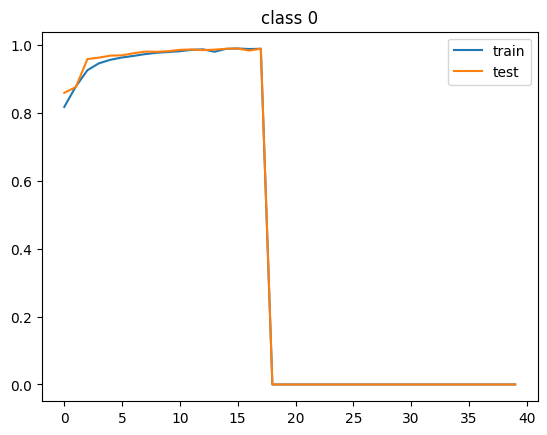

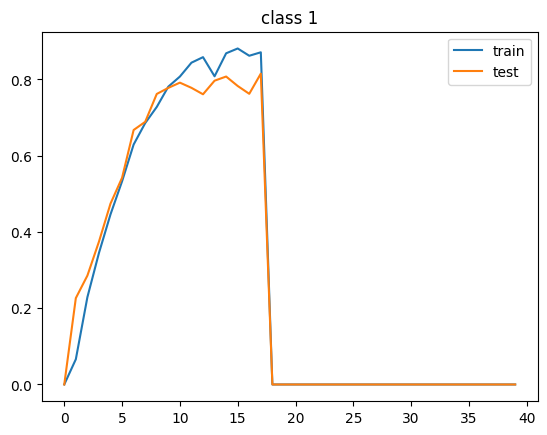

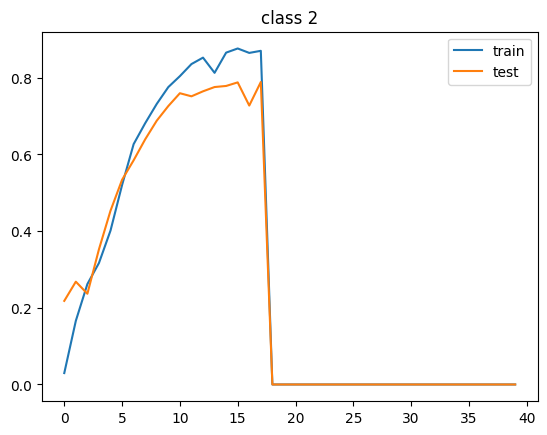

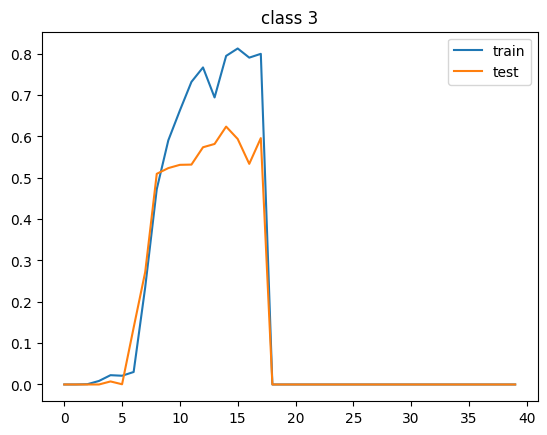

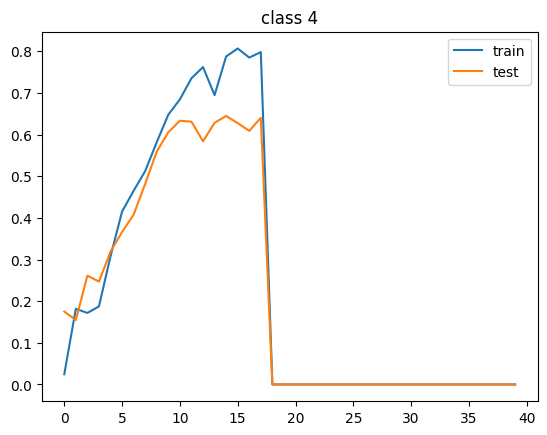

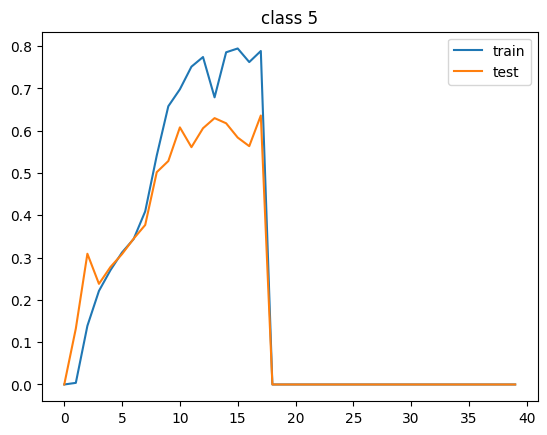

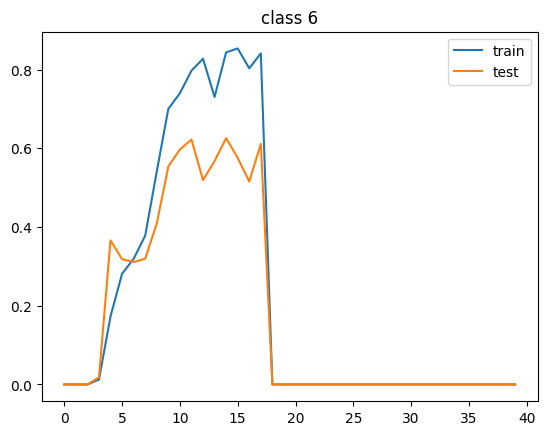

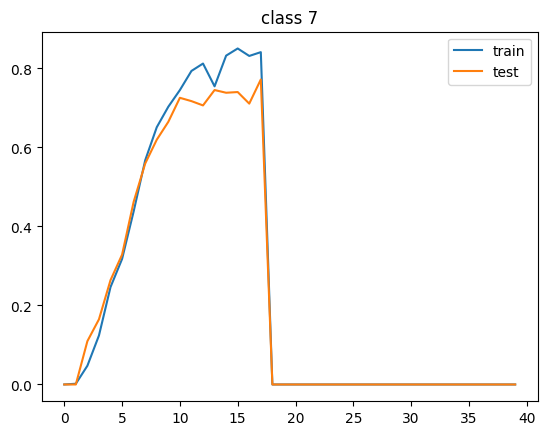

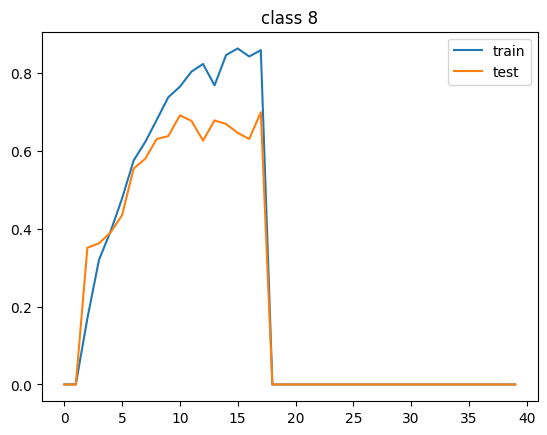

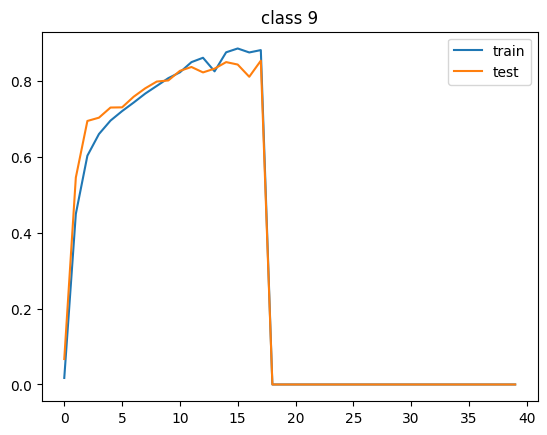

In [ ]:
for i in range(num_classes):
  plt.plot(dice_loss_train_store[:,i],label='train')
  plt.plot(dice_loss_test_store[:,i],label='test')
  plt.legend()
  plt.title(f'class {i}')
  plt.show()

In [18]:
path_to_model = 'model_big_classbalance_3000train_augment_background_mirror_rotate_gaussian_with_weights_bitemperedloss_29epochs_loss_553_1940_train_val_overfittingalotithink_lowestdice_class_score_5_080score_train_6_054_val_5_033_test_070_avg'
model = torch.load(path_to_model)

In [19]:
## Visualize results

def visualize_results(images, masks, num_examples):
    # Compares visually 'num_examples' of images with the actual and predicted mask

    # Predict masks with the model
    model.eval()
    with torch.no_grad():
        preds = model(images)

    # Take the argmax to get the class label for each pixel
    pred_masks = preds.argmax(dim=1)

    for i in range(num_examples if num_examples < batch_size else batch_size):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

        # Original image
        img = images[i].detach().cpu().permute((1, 2, 0)).numpy()   #.astype(int)
        cmap = 'gray' if grayscale else None
        ax1.imshow(img, cmap=cmap)
        ax1.set_title('Original Image')
        ax1.axis('off')

        # Actual mask
        true_mask = segment_image(images[i], masks[i]).permute((1, 2, 0)).long()
        ax2.imshow(true_mask)
        ax2.set_title('Actual Mask')
        ax2.axis('off')

        # Predicted mask
        pred_mask = segment_image(images[i], pred_masks[i]).permute((1, 2, 0)).long()
        ax3.imshow(pred_mask)
        ax3.set_title('Predicted Mask')
        ax3.axis('off')

        plt.show()


# Get a batch of images and masks from the dataloader
print('Train:')
images, masks = next(iter(train_dataloader))
images, masks = images.to(device), masks.to(device)
visualize_results(images, masks, num_examples=3)

print('Validation:')
images, masks = next(iter(validation_dataloader))
images, masks = images.to(device), masks.to(device)
visualize_results(images, masks, num_examples=3)

print('Test:')
images, masks = next(iter(test_dataloader))
images, masks = images.to(device), masks.to(device)
visualize_results(images, masks, num_examples=30)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

def calculate_accuracy(y_true, y_pred):
    accuracy = accuracy_score(y_true.flatten().detach().cpu().numpy(), y_pred.flatten().detach().cpu().numpy())
    return accuracy


def calculate_dice(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    dice_values = []
    for i in range(num_classes):
        intersection = np.sum((y_true == i) & (y_pred == i))
        total = np.sum(y_true == i) + np.sum(y_pred == i)
        dice = (2.0 * intersection + smooth) / (total + smooth)
        dice_values.append(dice)

    return np.mean(dice_values)

# def calculate_dice(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
#     dice_sum = 0.0
#     for i in range(num_classes):
#         true_class = (y_true == i)
#         pred_class = (y_pred == i)
#         intersection = torch.sum(true_class * pred_class)
#         union = torch.sum(true_class) + torch.sum(pred_class)
#         dice = (2.0 * intersection + smooth) / (union + smooth)
#         dice_sum += dice

#     return dice_sum/num_classes


def calculate_iou(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    iou_values = []
    for i in range(num_classes):
        intersection = np.sum(np.logical_and(y_true == i, y_pred == i))
        union = np.sum(np.logical_or(y_true == i, y_pred == i))
        iou = (intersection + smooth) / (union + smooth)
        iou_values.append(iou)

    return np.mean(iou_values)

# def calculate_iou(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
#     iou_sum = 0.0
#     for i in range(num_classes):
#         true_class = (y_true == i)
#         pred_class = (y_pred == i)
#         intersection = torch.sum(true_class * pred_class)
#         union = torch.sum(true_class) + torch.sum(pred_class) - intersection
#         iou = (intersection + smooth) / (union + smooth)
#         iou_sum += iou

#     return iou_sum/num_classes


def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.flatten().detach().cpu().numpy(),
        pred.flatten().detach().cpu().numpy(),
        normalize=normalize,
        labels=np.arange(num_classes)
    )


In [ ]:
## Evaluate test set

# Dice
test_dataloader = DataLoader(test_dataset, batch_size=30, shuffle=False, num_workers=num_workers)

confusion_matrix = np.zeros((num_classes, num_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    dice_scores_ve = []
    #iou_scores = []
    test_dice_scores = np.zeros(num_classes)
    for images, masks in test_dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        predictions = outputs.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller
        test_accuracies.append(calculate_accuracy(masks, predictions) * len(images))
        dice_scores = dice_coefficient(outputs.argmax(dim=1), masks, num_classes)
        dice_scores_ve.append(calculate_dice(masks, predictions))
        #iou_scores.append(calculate_iou(masks, predictions))
        test_dice_scores += np.nan_to_num(dice_scores)*len(images)

        ccm = compute_confusion_matrix(masks, predictions)
        confusion_matrix += ccm

    test_accuracy = np.sum(test_accuracies) / len(test_dataloader.dataset)
    dice_score_ve = np.mean(dice_scores)
    avg_dice_scores_test = test_dice_scores / len(test_dataloader.dataset)
    #iou_score = np.mean(iou_scores)

    model.train()

In [ ]:
print('Accuracy:', test_accuracy)
print('Dice:', dice_score_ve)
print('Dice for classes:', avg_dice_scores_test)
print('Avg dice:', np.mean(avg_dice_scores_test))
#print('IoU:', iou_score)

Accuracy: 0.8604095458984375
Dice: 0.6643112123012542
Dice for classes: [0.95379835 0.76895154 0.72312665 0.68459237 0.47626722 0.43530226
 0.52426046 0.69381022 0.60316467 0.77983838]
Avg dice: 0.6643112123012542


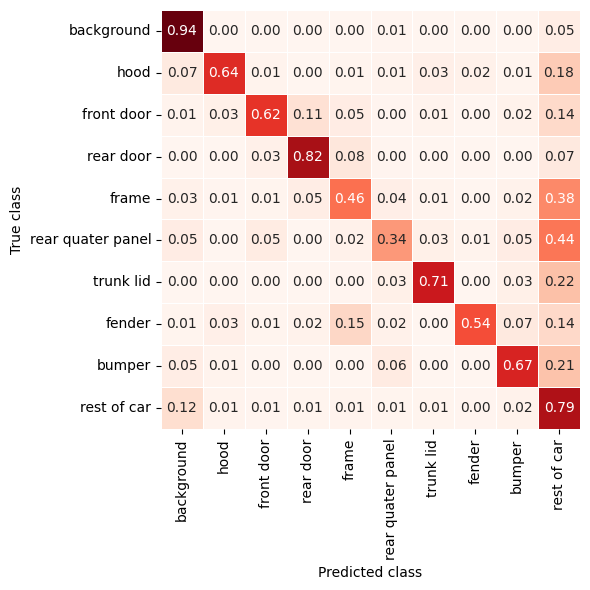

In [ ]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = car_parts
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

In [ ]:
# SÍÐAN TIL ÞESS AÐ FÁ GOTT MAT Á TESTING ACCURACY/DICE SCORE ÞÁ ER KANNSKI HÆGT AÐ NOTA AÐFERÐIR EINS OG Í COMPUTATIONAL TOOLS
# T.D. CROSS VALIDATION EÐA BOOTSTRAP VALIDATION (AÐ ÞVÍ AÐ VIÐ ERUM BARA MEÐ 30 TEST SAMPLES ÞANNIG AÐ ÞAÐ ER VARLA RAUNHÆFT AÐ META
# GÆÐIN BARA Á ÞEIM)